# E08: System with eight interacting species

In [31]:
import os, sys
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pymp # type: ignore

sys.path.append(os.path.abspath('../utils'))
import surd as surd
import it_tools as it

# Configure matplotlib to use LaTeX for text rendering and set font size
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

## System definition

In [32]:
def eight_species(N, noise=0.005):
    
    # Initialize arrays for the state variables with zeros
    q1,q2,q3,q4,q5,q6,q7,q8 = np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N),np.zeros(N)
    
    # Initialize arrays for the noise terms with random normal values
    eta1,eta2,eta3,eta4,eta5,eta6,eta7,eta8 = np.random.normal(0, noise, N), np.random.normal(0, 0.005, N), np.random.normal(0, 0.005, N), np.random.normal(0, 0.005, N), np.random.normal(0, 0.005, N), np.random.normal(0, 0.005, N), np.random.normal(0, 0.005, N), np.random.normal(0, 0.005, N)

    # Set initial conditions
    q1[0], q2[0], q3[0], q4[0], q5[0], q6[0], q7[0], q8[0] = 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
    
    # Simulate the system over N time steps
    for t in range(0, N-1):
        q1[t+1] = q1[t] * (3.9 - 3.9 * q1[t]) + eta1[t]
        q2[t+1] = q2[t] * (3.5 - 3.5 * q2[t]) + eta2[t]
        q3[t+1] = q3[t] * (3.62 - 3.62 * q3[t] - 0.35 * q1[t] - 0.35 * q2[t]) + eta3[t]
        q4[t+1] = q4[t] * (3.75 - 3.75 * q4[t] - 0.35 * q2[t]) + eta4[t]
        q5[t+1] = q5[t] * (3.65 - 3.65 * q5[t] - 0.35 * q3[t]) + eta5[t]
        q6[t+1] = q6[t] * (3.72 - 3.72 * q6[t] - 0.35 * q3[t]) + eta6[t]
        q7[t+1] = q7[t] * (3.57 - 3.57 * q7[t] - 0.35 * q6[t]) + eta7[t]
        q8[t+1] = q8[t] * (3.68 - 3.68 * q8[t] - 0.35 * q6[t]) + eta8[t]

    return q1, q2, q3, q4, q5, q6, q7, q8


## Problem set-up

In [33]:
Nt = 10**7              # Number of time steps to perform the integration of the system
samples = Nt-10000      # Number of samples to be considered (remove the transients)

qs = eight_species(Nt)
X = np.array([q[-samples:] for q in qs])
nlag = 1
nbins = 50
max_combs = 3
Nvars = 8
cores = 4

## Causality analysis

In this example, we will calculate the causalities in parallel using `cores = 4` and we will limit the order of synergistic causalities to `max_combs = 3`. The latter implies that only synergies between the target and combinations of up to three variables will be calculated.

In [34]:
Rd_results = pymp.shared.dict({})  # Dictionary to store redundant contributions
Sy_results = pymp.shared.dict({})  # Dictionary to store synergistic contributions
MI_results = pymp.shared.dict({})   # Dictionary to store mutual information results
info_leak_results = pymp.shared.dict({})  # Dictionary to store information leak results

with pymp.Parallel(cores) as par:
    for i in par.range(Nvars):
        Y = np.vstack([X[i, nlag:], X[:, :-nlag]])  # Organize data

        # Run SURD
        Rd, Sy, MI = surd.surd_hd(Y, nbins, max_combs)

        # Calculate information leak
        hist = it.myhistogram(Y[0,:].T, nbins)
        H  = it.entropy_nvars(hist, (0,) )
        info_leak = 1 - (sum(Rd.values()) + sum(Sy.values())) / H
        
        # Print results
        print(f'SURD CAUSALITY FOR SIGNAL {i+1}')
        # surd.nice_print(Rd, Sy, MI, info_leak)
        # print('\n')
        Rd_results[i+1], Sy_results[i+1], MI_results[i+1], info_leak_results[i+1] = Rd, Sy, MI, info_leak

SURD CAUSALITY FOR SIGNAL 1
SURD CAUSALITY FOR SIGNAL 7
SURD CAUSALITY FOR SIGNAL 5
SURD CAUSALITY FOR SIGNAL 3
SURD CAUSALITY FOR SIGNAL 2
SURD CAUSALITY FOR SIGNAL 8
SURD CAUSALITY FOR SIGNAL 6
SURD CAUSALITY FOR SIGNAL 4


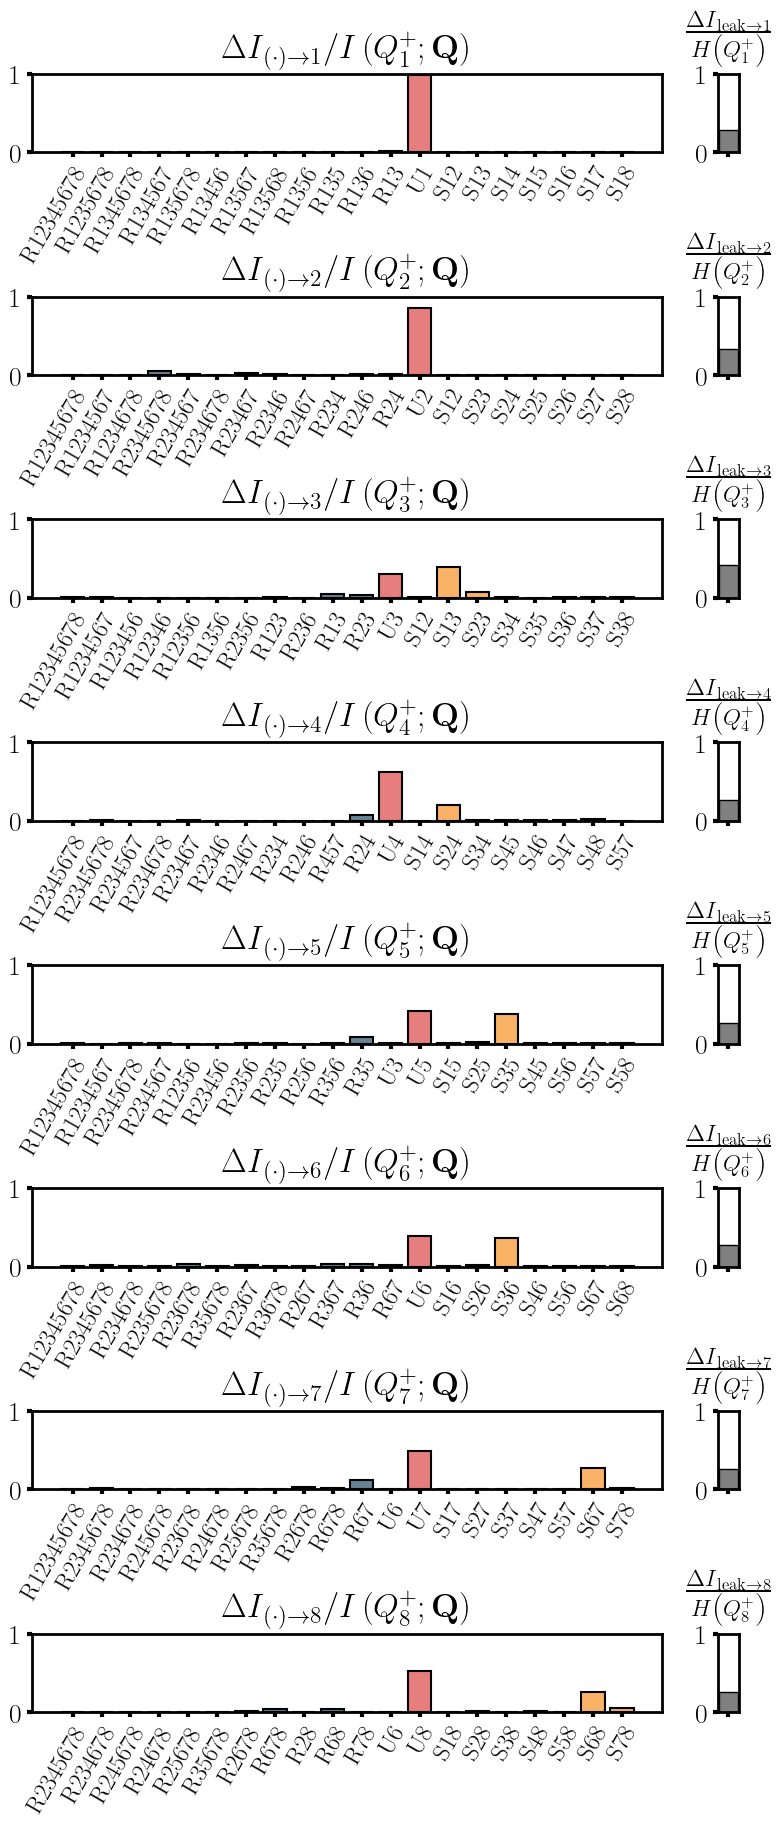

In [35]:
fig, axs = plt.subplots(Nvars, 2, figsize=(11, 2.3*Nvars), gridspec_kw={'width_ratios': [60, 1]})
for i in range(Nvars):
    # Plot SURD
    _ = surd.plot_nlabels(Rd_results[i+1], Sy_results[i+1], info_leak_results[i+1], axs[i,:], Nvars, nlabels=20)
    # Plot formatting
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$', pad=12)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1}^+ \\right)}}$', pad=25)
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=18, rotation = 60, ha = 'right', rotation_mode='anchor')
    axs[i,0].set_box_aspect(1/8)
    axs[i,1].set_yticks([0,1])
    axs[i,0].set_yticks([0,1])
    axs[i,0].set_ylim([0,1])
# Show the results
# for i in range(0,Nvars-1):
#     axs[i,0].set_xticklabels('')
plt.tight_layout(w_pad=-10, h_pad=1.5)